Embryo Classificiation using CNN

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 19.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
pip install tabulate

# Table of Contents
<a id="toc"></a>
- [1. Import Libraries](#1)
- [2. Read Dataset](#2)
- [3. Visualization](#3)
- [4. Preprocessing](#4)
- [5. Modeling](#5)
- [6. Predict test data](#6)
- [7. Submission](#7)   

<a id="1"></a>
# **<center><span style="color:#005dc4;">Import Libraries</span></center>**

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms.v2 as t
from torchvision import models
import torch.nn as nn
from sklearn.metrics import accuracy_score, roc_auc_score
import torch.nn.functional as F
from tabulate import tabulate
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split
import gc
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline



<a id="2"></a>
# **<center><span style="color:#005dc4;">Read Dataset</span></center>**

*descriptions:*
> * **ROOT_PATH** - path source for all files.
> * **train_df** - train.csv file.
> * **test_df** - test.csv file.

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ROOT_PATH = "/content/drive/MyDrive/ColabNotebooks/hvwc23/"
train_df = pd.read_csv(f'{ROOT_PATH}/train.csv')
test_df = pd.read_csv(f'{ROOT_PATH}/test.csv')


In [ ]:
print(train_df.shape)


(840, 2)


In [ ]:
print(test_df.shape)

(180, 2)


In [ ]:
def preprocess_jpeg(jpeg_path):

    img = cv2.imread(jpeg_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))

    return img

In [ ]:
print(train_df.shape)

(840, 3)


In [ ]:
print(test_df.shape)

(180, 3)


[716 124]


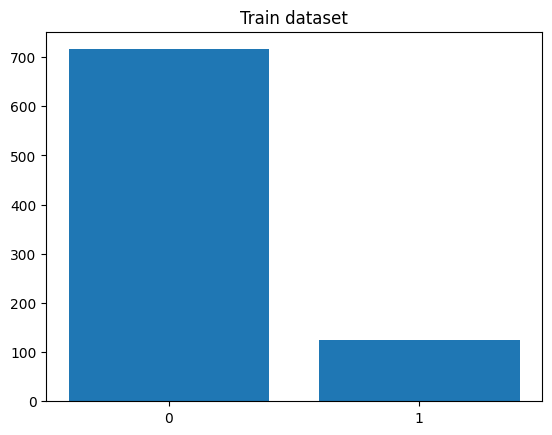

In [ ]:
# all data visualization
labels = train_df['Class'].value_counts()
plt.bar(['0','1'], labels.values)
print(labels.values)
plt.title('Train dataset')
plt.show()

In [ ]:

# add one column 'path'
train_df['path'] = ROOT_PATH +'train/'+ train_df['Image']
train_df['path']

0      /content/drive/MyDrive/ColabNotebooks/hvwc23/t...
1      /content/drive/MyDrive/ColabNotebooks/hvwc23/t...
2      /content/drive/MyDrive/ColabNotebooks/hvwc23/t...
3      /content/drive/MyDrive/ColabNotebooks/hvwc23/t...
4      /content/drive/MyDrive/ColabNotebooks/hvwc23/t...
                             ...                        
835    /content/drive/MyDrive/ColabNotebooks/hvwc23/t...
836    /content/drive/MyDrive/ColabNotebooks/hvwc23/t...
837    /content/drive/MyDrive/ColabNotebooks/hvwc23/t...
838    /content/drive/MyDrive/ColabNotebooks/hvwc23/t...
839    /content/drive/MyDrive/ColabNotebooks/hvwc23/t...
Name: path, Length: 840, dtype: object

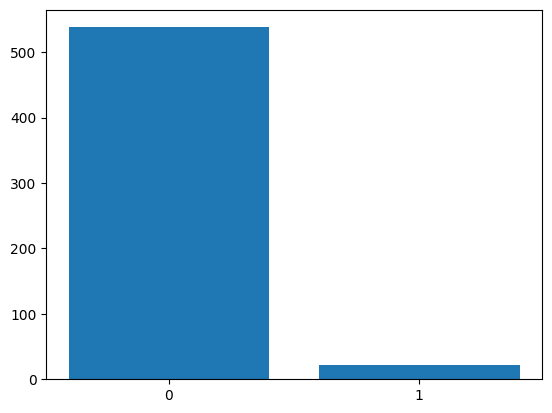

[538  22]


In [ ]:

# contain D3 images
D3 = train_df['Image'].apply(lambda x: 'D3_' in x)
labels = train_df[D3]['Class'].value_counts()
plt.bar(['0','1'], labels.values)
plt.show()
print(labels.values)

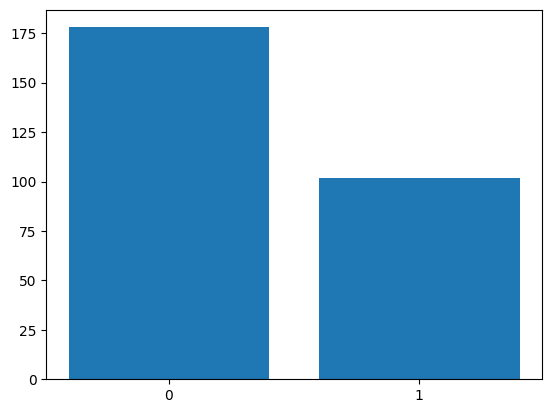

[178 102]


In [ ]:


# contain D5 images
D5 = train_df['Image'].apply(lambda x: 'D5_' in x)
labels = train_df[D5]['Class'].value_counts()
plt.bar(['0','1'], labels.values)
plt.show()
print(labels.values)


In [ ]:
def preprocess_jpeg(jpeg_path):

    img = cv2.imread(jpeg_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (28, 28))

    return img

In [ ]:
#split class 0 and 1
Class0 = train_df[train_df['Class'] == 0].values
Class1 = train_df[train_df['Class'] == 1].values

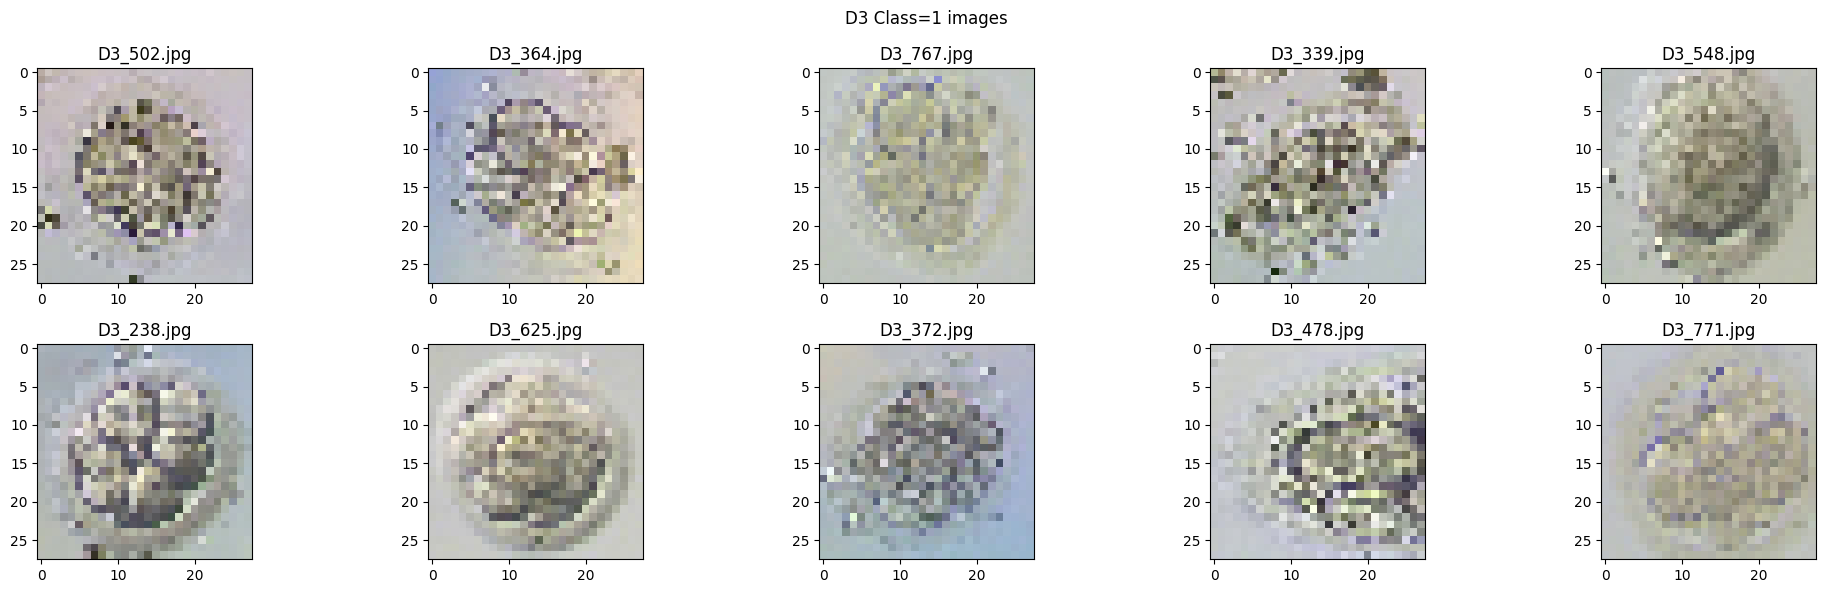

In [ ]:
#D3 Class=1
fig, axes = plt.subplots(2, 5, figsize=(20, 6))
axes = axes.flatten()

# Plot each image
for i in range(10):
    ax = axes[i]
    ax.imshow(preprocess_jpeg(Class1[i][2]))  #D3=i  D5=-i-1
    ax.set_title(Class1[i][0])  #name

plt.suptitle('D3 Class=1 images')
plt.tight_layout()
plt.show()

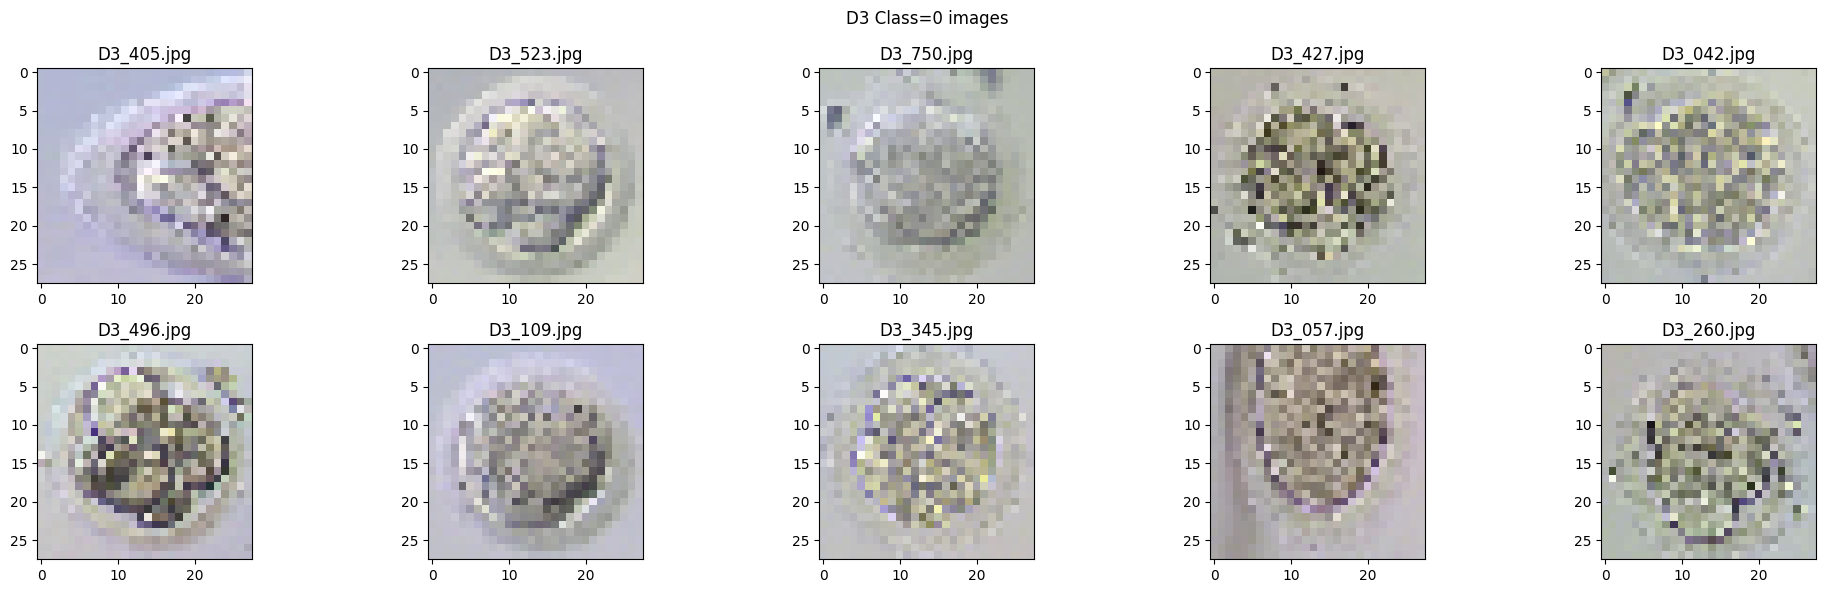

In [ ]:
#D3 Class=0
fig, axes = plt.subplots(2, 5, figsize=(20, 6))
axes = axes.flatten()

# Plot each image
for i in range(10):
    ax = axes[i]
    ax.imshow(preprocess_jpeg(Class0[i][2]))  #D3=i  D5=-i-1
    ax.set_title(Class0[i][0])  #name

plt.suptitle('D3 Class=0 images')
plt.tight_layout()
plt.show()

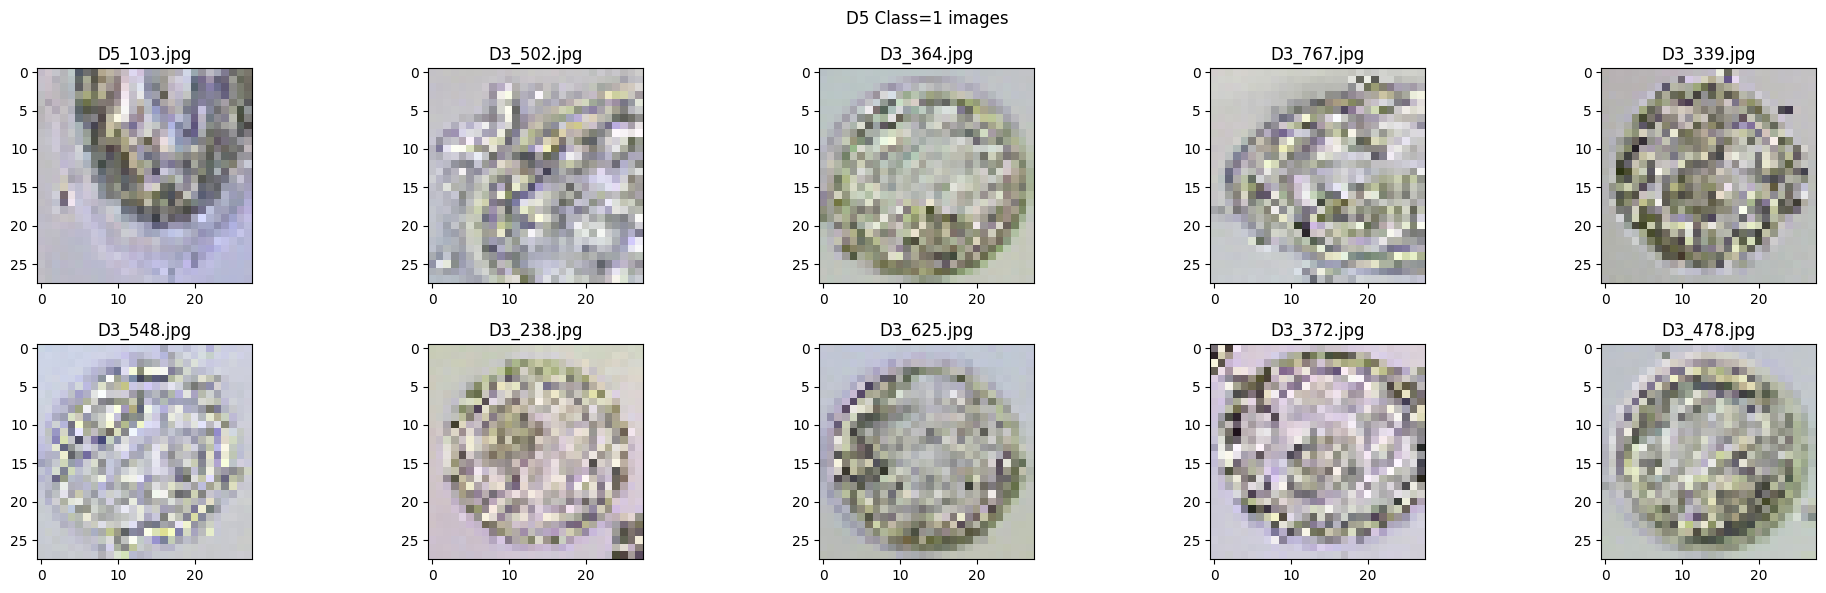

In [ ]:
#D5 Class=1
fig, axes = plt.subplots(2, 5, figsize=(20, 6))
axes = axes.flatten()

# Plot each image
for i in range(10):
    ax = axes[i]
    ax.imshow(preprocess_jpeg(Class1[-i-1][2]))  #D3=i  D5=-i-1
    ax.set_title(Class1[i-1][0])  #name

plt.suptitle('D5 Class=1 images')
plt.tight_layout()
plt.show()

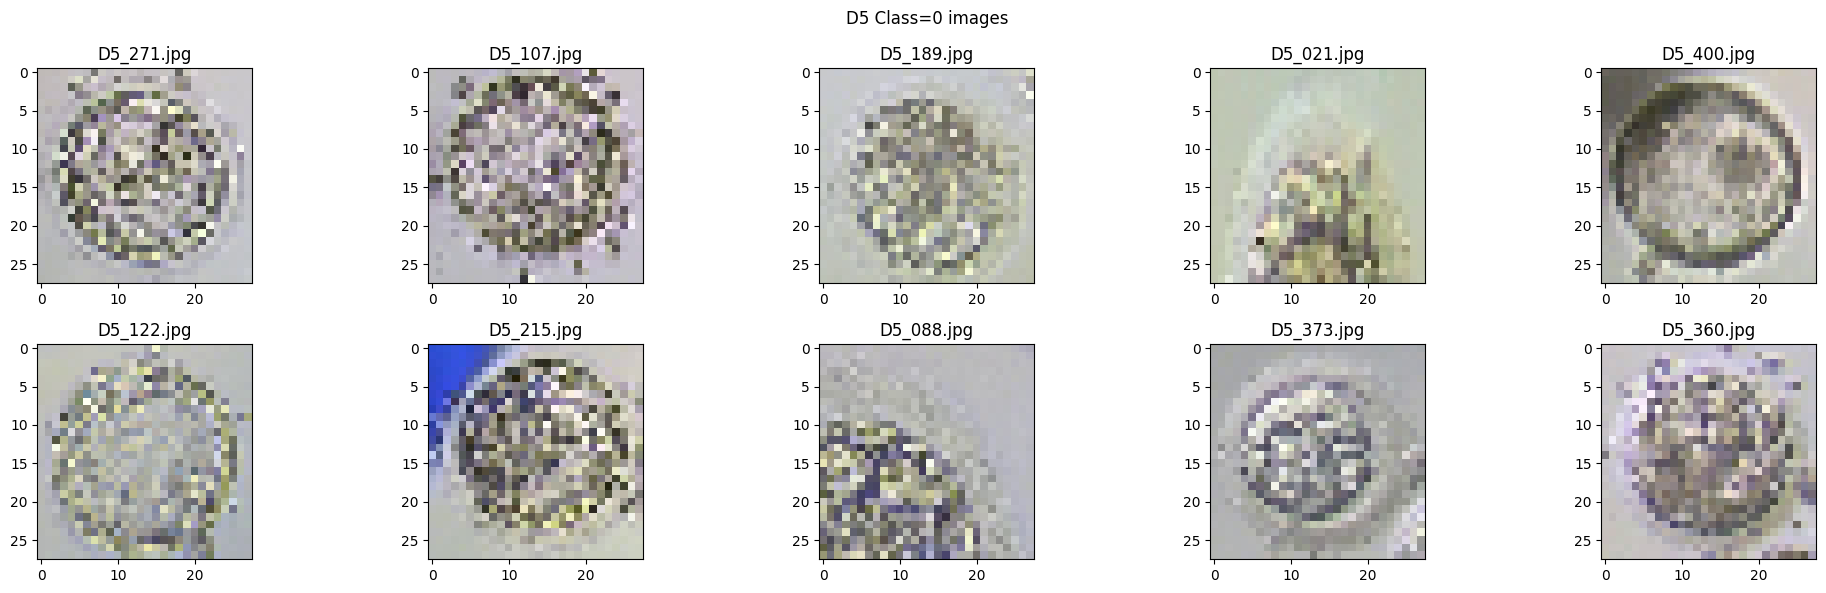

In [ ]:
#D5 Class=0
fig, axes = plt.subplots(2, 5, figsize=(20, 6))
axes = axes.flatten()

# Plot each image
for i in range(10):
    ax = axes[i]
    ax.imshow(preprocess_jpeg(Class0[-i-1][2]))  #D3=i  D5=-i-1
    ax.set_title(Class0[-i-1][0])  #name

plt.suptitle('D5 Class=0 images')
plt.tight_layout()
plt.show()

In [ ]:
from torch.utils.data import WeightedRandomSampler

In [ ]:
class EmbryoData(Dataset):
    def __init__(self, df, current_fold, training=True, num_fold = 5):
        super().__init__()

        self.df = df
        self.train = training
        if self.train:
            self.transform = transforms.Compose([
                            t.RandomHorizontalFlip(p=0.5),
                            t.RandomVerticalFlip(p=0.5),
                            t.RandomRotation(degrees=15),

                            t.ToTensor(),
                        ])
        else:
            self.transform = transforms.Compose([
                            t.ToTensor(),
                        ])
        self.num_fold = num_fold
        self.current_fold = current_fold
        self.kf = KFold(n_splits=num_fold)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img = preprocess_jpeg(self.df['path'][idx])
        if self.train:
            image = self.transform(img)
            label = self.df['Class'][idx]
            return image, label
        else:
            image = self.transform(img)
            return image

    def get_splits(self):
        """
        Splits the dataset into training and validation subsets based on the current fold.

        Returns:
            tuple: A tuple containing the training and validation subsets.
        """

        fold_data = list(self.kf.split(self.df['path']))
        train_indices, val_indices = fold_data[self.current_fold]

        train_data = self._get_subset(train_indices, training=True)
        val_data = self._get_subset(val_indices, training=False)

        return train_data, val_data

    def _get_subset(self, indices, training):
        """
        Returns a subset of the dataset based on the provided indices.

        Args:
            indices (list): List of indices to include in the subset.

        Returns:
            Subset: A subset of the dataset.
        """
        self.training = training
        return Subset(self, indices)

In [ ]:
def calculate_weights_for_balanced_classes(df, label_column):
    # Count all classes
    class_counts = df[label_column].value_counts().to_dict()

    # Calculate weights
    num_samples = len(df)
    weights = []

    for idx, row in df.iterrows():
        label_value = row[label_column]
        weight = num_samples / class_counts[label_value]
        weights.append(weight)

    return weights

In [ ]:
BATCH_SIZE = 64  # Adjust as needed
NUM_EPOCHS = 15
LR = 1e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
threshold = 0.46

cpu


In [ ]:
D3 = train_df['Image'].apply(lambda x: 'D3_' in x)
train_df_d3 = train_df[D3]
train_df_d3.head()



,Image,Class,path
0,D3_405.jpg,0,/content/drive/MyDrive/ColabNotebooks/hvwc23/t...
1,D3_523.jpg,0,/content/drive/MyDrive/ColabNotebooks/hvwc23/t...
2,D3_750.jpg,0,/content/drive/MyDrive/ColabNotebooks/hvwc23/t...
3,D3_427.jpg,0,/content/drive/MyDrive/ColabNotebooks/hvwc23/t...
4,D3_042.jpg,0,/content/drive/MyDrive/ColabNotebooks/hvwc23/t...


In [ ]:
D5 = train_df['Image'].apply(lambda x: 'D5_' in x)
train_df_d5 = train_df[D5].reset_index().drop(['index'], axis=1)
train_df_d5.head()

,Image,Class,path
0,D5_158.jpg,1,/content/drive/MyDrive/ColabNotebooks/hvwc23/t...
1,D5_110.jpg,0,/content/drive/MyDrive/ColabNotebooks/hvwc23/t...
2,D5_018.jpg,0,/content/drive/MyDrive/ColabNotebooks/hvwc23/t...
3,D5_348.jpg,1,/content/drive/MyDrive/ColabNotebooks/hvwc23/t...
4,D5_025.jpg,0,/content/drive/MyDrive/ColabNotebooks/hvwc23/t...


In [ ]:
#5-fold
def dataloader(train_df):
    train_data_0, val_data_0 = EmbryoData(train_df, current_fold=0).get_splits()
    train_data_1, val_data_1 = EmbryoData(train_df, current_fold=1).get_splits()
    train_data_2, val_data_2 = EmbryoData(train_df, current_fold=2).get_splits()
    train_data_3, val_data_3 = EmbryoData(train_df, current_fold=3).get_splits()
    train_data_4, val_data_4 = EmbryoData(train_df, current_fold=4).get_splits()

    train_dataloader_0 = DataLoader(train_data_0,batch_size = BATCH_SIZE, shuffle = True)
    val_dataloader_0 = DataLoader(val_data_0,batch_size = BATCH_SIZE, shuffle = False)
    train_dataloader_1 = DataLoader(train_data_1,batch_size = BATCH_SIZE, shuffle = True)
    val_dataloader_1 = DataLoader(val_data_1,batch_size = BATCH_SIZE, shuffle = False)
    train_dataloader_2 = DataLoader(train_data_2,batch_size = BATCH_SIZE, shuffle = True)
    val_dataloader_2 = DataLoader(val_data_2,batch_size = BATCH_SIZE, shuffle = False)
    train_dataloader_3 = DataLoader(train_data_3,batch_size = BATCH_SIZE, shuffle = True)
    val_dataloader_3 = DataLoader(val_data_3,batch_size = BATCH_SIZE, shuffle = False)
    train_dataloader_4 = DataLoader(train_data_4,batch_size = BATCH_SIZE, shuffle = True)
    val_dataloader_4 = DataLoader(val_data_4,batch_size = BATCH_SIZE, shuffle = False)

    dataloaders = [(train_dataloader_0, val_dataloader_0),
                   (train_dataloader_1, val_dataloader_1),
                   (train_dataloader_2, val_dataloader_2),
                   (train_dataloader_3, val_dataloader_3),
                   (train_dataloader_4, val_dataloader_4)]

    return dataloaders

In [ ]:
dataloaders_d3 = dataloader(train_df_d3)
dataloaders_d5 = dataloader(train_df_d5)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [ ]:

class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()


#        self.feature_extractor = models.resnet152(weights = 'IMAGENET1K_V2')
#        self.feature_extractor = models.resnet18(weights = 'IMAGENET1K_V1')
#        f = self.feature_extractor.fc.in_features
#        self.feature_extractor.fc = nn.Identity()


        self.feature_extractor = models.efficientnet_b2(weights = 'IMAGENET1K_V1')  #
        f = self.feature_extractor.classifier[1].in_features  #efficientnet_b0
        self.feature_extractor.classifier[1] = nn.Identity()  #efficientnet_b0

        self.logit = nn.Sequential(
            nn.Linear(f, 32),
            nn.SiLU(),
            nn.Dropout(0.4),
            nn.Linear(32, 1)
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        output = self.logit(x)
        output = output.squeeze(1)

        return output


In [ ]:
model_d3 = CNNModel().to(device)
model_d5 = CNNModel().to(device)

In [ ]:
class MetricsCalculator:

    def __init__(self):

        self.probabilities = []
        self.predictions = []
        self.targets = []


    def update(self, logits, target):
        """
        Update the metrics calculator with predicted values and corresponding targets.

        Args:
            predicted (torch.Tensor): Predicted values.
            target (torch.Tensor): Ground truth targets.
        """
        probabilities = torch.sigmoid(logits)
        predicted = (probabilities > 0.5)

        self.probabilities.extend(probabilities.detach().cpu().numpy())
        self.predictions.extend(predicted.detach().cpu().numpy())
        self.targets.extend(target.detach().cpu().numpy())

    def reset(self):
        """Reset the stored predictions and targets."""

        self.probabilities = []
        self.predictions = []
        self.targets = []

    def compute_accuracy(self):
        """
        Compute the accuracy metric.

        Returns:
            float: Accuracy.
        """
        return accuracy_score(self.targets, self.predictions)

    def compute_auc(self):
        """
        Compute the AUC (Area Under the Curve) metric.

        Returns:
            float: AUC.
        """

        return roc_auc_score(self.targets, self.probabilities)

In [ ]:
def train(dataloaders, model):
    prev_val_best_loss = float('inf')
    best_model = None
    train_acc = MetricsCalculator()
    val_acc = MetricsCalculator()

    optimizer = torch.optim.Adam(model.parameters(), lr = LR)
    bce_ = nn.BCEWithLogitsLoss(pos_weight = torch.tensor([2.0]).to(device))
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)

    for epoch in range(NUM_EPOCHS):

        # training
        model.train()

        train_loss = 0.0
        val_loss = 0.0

        print(f'Epoch: [{epoch + 1}/{NUM_EPOCHS}]')

        train_loader, val_loader = dataloaders[epoch%5]
        print(f'Fold: {epoch%5}')

        for idx, data in enumerate(train_loader):
            images, labels = data[0].to(device), data[1].to(device)

            optimizer.zero_grad()
            outputs = model(images)

            loss = bce_(outputs, labels.float())
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            train_acc.update(outputs, labels)

        train_loss = train_loss/(idx+1)

        # validation
        model.eval()
        for idx, data in enumerate(val_loader):
            inputs, labels = data[0].to(device), data[1].to(device)


            outputs = model(inputs)
            loss = bce_(outputs, labels.float())
            val_loss += loss.item()
            val_acc.update(outputs, labels)

        val_loss = val_loss/(idx+1)
        scheduler.step(val_loss)

        if val_loss < prev_val_best_loss:
            prev_val_best_loss = val_loss
            print("Validation Loss improved, Saving Model...")
            best_model = model

        metrics = [[train_acc.compute_accuracy(),
                    val_acc.compute_accuracy(),
                  train_acc.compute_auc(),
                  val_acc.compute_auc()]]

        # verbose
        print('')
        print(tabulate(metrics, headers=["Train Acc", "Val Acc", "Train AUC", "Val AUC"]))

        print(f'\nMean Train Loss: {train_loss:.3f}')
        print(f'Mean Val Loss: {val_loss:.3f}\n')

        train_acc.reset()
        val_acc.reset()

    return best_model

In [ ]:
best_model_d3 = train(dataloaders_d3, model_d3)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch: [1/15]
Fold: 0
Validation Loss improved, Saving Model...

  Train Acc    Val Acc    Train AUC    Val AUC
-----------  ---------  -----------  ---------
   0.408482  0.0446429      0.52445   0.374214

Mean Train Loss: 0.740
Mean Val Loss: 0.826

Epoch: [2/15]
Fold: 1

  Train Acc    Val Acc    Train AUC    Val AUC
-----------  ---------  -----------  ---------
   0.540179  0.0535714     0.616753   0.369497

Mean Train Loss: 0.708
Mean Val Loss: 0.829

Epoch: [3/15]
Fold: 2
Validation Loss improved, Saving Model...

  Train Acc    Val Acc    Train AUC    Val AUC
-----------  ---------  -----------  ---------
   0.645089   0.294643     0.602871    0.69419

Mean Train Loss: 0.684
Mean Val Loss: 0.736

Epoch: [4/15]
Fold: 3
Validation Loss improved, Saving Model...

  Train Acc    Val Acc    Train AUC    Val AUC
-----------  ---------  -----------  ---------
   0.700893   0.607143     0.609432   0.416667

Mean Train Loss: 0.657
Mean Val Loss: 0.684

Epoch: [5/15]
Fold: 4
Validation L

In [ ]:
best_model_d5 = train(dataloaders_d5, model_d5)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch: [1/15]
Fold: 0
Validation Loss improved, Saving Model...

  Train Acc    Val Acc    Train AUC    Val AUC
-----------  ---------  -----------  ---------
   0.544643   0.357143     0.582789       0.25

Mean Train Loss: 0.932
Mean Val Loss: 0.975

Epoch: [2/15]
Fold: 1
Validation Loss improved, Saving Model...

  Train Acc    Val Acc    Train AUC    Val AUC
-----------  ---------  -----------  ---------
   0.433036   0.321429     0.486565    0.55848

Mean Train Loss: 0.955
Mean Val Loss: 0.918

Epoch: [3/15]
Fold: 2

  Train Acc    Val Acc    Train AUC    Val AUC
-----------  ---------  -----------  ---------
        0.5   0.357143     0.499957   0.527891

Mean Train Loss: 0.944
Mean Val Loss: 0.950

Epoch: [4/15]
Fold: 3

  Train Acc    Val Acc    Train AUC    Val AUC
-----------  ---------  -----------  ---------
   0.580357        0.5     0.646711    0.62963

Mean Train Loss: 0.885
Mean Val Loss: 1.003

Epoch: [5/15]
Fold: 4
Validation Loss improved, Saving Model...

  Train Acc

In [ ]:
test_df['path'] = ROOT_PATH +'test/'+ test_df['Image']
test_df['path'][0]

'/content/drive/MyDrive/ColabNotebooks/hvwc23/test/D3_693.jpg'

In [ ]:
D5_ = test_df['Image'].apply(lambda x: 'D5_' in x)
test_df_d5 = test_df[D5_].reset_index().drop(['index'], axis=1)
test_df_d5.head()

,ID,Image,path
0,121,D5_251.jpg,/content/drive/MyDrive/ColabNotebooks/hvwc23/t...
1,122,D5_226.jpg,/content/drive/MyDrive/ColabNotebooks/hvwc23/t...
2,123,D5_386.jpg,/content/drive/MyDrive/ColabNotebooks/hvwc23/t...
3,124,D5_315.jpg,/content/drive/MyDrive/ColabNotebooks/hvwc23/t...
4,125,D5_248.jpg,/content/drive/MyDrive/ColabNotebooks/hvwc23/t...


In [ ]:
D3_ = test_df['Image'].apply(lambda x: 'D3_' in x)
test_df_d3 = test_df[D3_].reset_index().drop(['index'], axis=1)
test_df_d3.head()

,ID,Image,path
0,1,D3_693.jpg,/content/drive/MyDrive/ColabNotebooks/hvwc23/t...
1,2,D3_212.jpg,/content/drive/MyDrive/ColabNotebooks/hvwc23/t...
2,3,D3_724.jpg,/content/drive/MyDrive/ColabNotebooks/hvwc23/t...
3,4,D3_623.jpg,/content/drive/MyDrive/ColabNotebooks/hvwc23/t...
4,5,D3_210.jpg,/content/drive/MyDrive/ColabNotebooks/hvwc23/t...


In [ ]:
test_dataset_d3 =  EmbryoData(test_df_d3, current_fold = 0,training=False)
test_loader_d3 = DataLoader(test_dataset_d3, batch_size=BATCH_SIZE, shuffle=False)
test_dataset_d5 =  EmbryoData(test_df_d5, current_fold = 0,training=False)
test_loader_d5 = DataLoader(test_dataset_d5, batch_size=BATCH_SIZE, shuffle=False)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [ ]:
def test(best_model, test_loader):
    best_model.eval()
    model_preds = []

    with torch.no_grad():
        # Test out inference with 5 samples
        for idx, data in enumerate(test_loader):
            images = data.to(device)

            predicts = best_model(images)
            preds =F.sigmoid(predicts.cpu()).numpy().flatten()
            y_pred = (preds > threshold).astype(int)
            model_preds.extend(y_pred.tolist())

    return model_preds

In [ ]:
model_preds_d3 = test(best_model_d3, test_loader_d3)
model_preds_d5 = test(best_model_d5, test_loader_d5)
model_preds = np.append(model_preds_d3, model_preds_d5)

In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/hvwc23/submission.csv')
submission['Class'] = model_preds

In [ ]:
submission.to_csv('submission.csv',index=False)
submission

,ID,Class
0,1,0
1,2,0
2,3,0
3,4,0
4,5,1
...,...,...
175,176,1
176,177,1
177,178,1
178,179,0


from matplotlib import pyplot as plt
submission['ID'].plot(kind='hist', bins=20, title='ID')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
submission['Class'].plot(kind='hist', bins=20, title='Class')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
submission.plot(kind='scatter', x='ID', y='Class', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['ID']
  ys = series['Class']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = submission.sort_values('ID', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('ID')
_ = plt.ylabel('Class')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['ID']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'ID'}, axis=1)
              .sort_values('ID', ascending=True))
  xs = counted['ID']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = submission.sort_values('ID', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('ID')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
submission['ID'].plot(kind='line', figsize=(8, 4), title='ID')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
submission['Class'].plot(kind='line', figsize=(8, 4), title='Class')
plt.gca().spines[['top', 'right']].set_visible(False)